In [19]:
import uproot
import coffea
from coffea import hist
import numpy as np
import seutils
from math import pi
import math

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import utils
import networkx as nx
import imp

In [11]:
imp.reload(utils)

<module 'utils' from '/uscms_data/d3/klijnsma/hgcal/history/flatntup-interpretation/utils.py'>

In [4]:
hits, tracks, vertices = utils.get_ntup('hgcalhistoryntuple_numEvent10.root')

print(hits.keys())
print(tracks.keys())
print(vertices.keys())

# Make a filter to get only events with a somewhat energetic photon
photon_energies = tracks[b'simtrack_momentum'].E[tracks[b'simtrack_pdgid'] == 22]
filter_energetic_photon = (photon_energies > 50.).count_nonzero() > 0

dict_keys([b'simhit_detid', b'simhit_x', b'simhit_y', b'simhit_z', b'simhit_eta', b'simhit_phi', b'simhit_pt', b'simhit_zside', b'simhit_siThickness', b'simhit_radiusToSide', b'simhit_siThickIndex', b'simhit_layer', b'simhit_layerWithOffset', b'simhit_isHalfCell', b'simhit_isSilicon', b'simhit_inEE', b'simhit_inHsi', b'simhit_inHsc', b'simhit_energy', b'simhit_emFraction', b'simhit_time', b'simhit_trackId', b'simhit_depth'])
dict_keys([b'simtrack_x', b'simtrack_y', b'simtrack_z', b'simtrack_momentum', b'simtrack_trackId', b'simtrack_vertexIndex', b'simtrack_pdgid'])
dict_keys([b'simvertex_x', b'simvertex_y', b'simvertex_z', b'simvertex_t', b'simvertex_id', b'simvertex_parentTrackId', b'simvertex_processType', b'simvertex_noParent'])


In [40]:
class HitsPlotMaker(object):
    PDGID_COLORS = {
        13 : 'xkcd:light blue', # muon
        11 : 'g', # electron
        22 : 'r', # photon
        211 : 'xkcd:orange', # pion
        }
    
    def __init__(self):
        super(HitsPlotMaker, self).__init__()
        # Get the minimum and maximum z positions of HGCAL
        self.zmin_pos = min(utils.z_pos_layers)
        self.zmax_pos = max(utils.z_pos_layers)
        self.zmin_neg = min(utils.z_neg_layers)
        self.zmax_neg = max(utils.z_neg_layers)
        # self.xmin = -250.
        # self.xmax = 250.
        self.xmin = -100.
        self.xmax = 100.
    
    def color(self, pdgid):
        """Returns a matplotlib color string for a PDG ID"""
        return self.PDGID_COLORS.get(abs(pdgid), 'xkcd:light grey')
    
    def plot_hits_in_sector(
            self,
            ax,
            event,
            endcap='+',
            coord='x',
            pdgid=None
            ):
        """Makes a plot with hits and tracks for one segment of HGCAL for one coordinate"""
        plt.sca(ax)

        # Plot some straight lines at some layer positions
        for layer in [1, 5, 10, 27 ]:
            z = utils.get_z_for_layer(layer, endcap)
            plt.text(
                z, 0.8*self.xmax, str(layer),
                horizontalalignment='left' if endcap=='+' else 'right',
                color = 'xkcd:light grey'
                )
            ax.plot([z, z], [self.xmin, self.xmax], c='xkcd:light grey')

        # Plot the tracks
        for i in range(event.track_z.shape[0]):
            z = [ event.track_vertex_z[i], event.track_z[i] ]
            # Stop prematurely for tracks outside of hgcal, since ax.plot is pretty slow
            zmin = self.zmin_pos if endcap == '+' else self.zmin_neg
            zmax = self.zmax_pos if endcap == '+' else self.zmax_neg
            if z[0] < zmin and z[1] < zmin:
                continue
            elif z[0] > zmax and z[1] > zmax:
                continue
            
            x = [ event.track_vertex_x[i], event.track_x[i] ] if coord == 'x' else [ event.track_vertex_y[i], event.track_y[i] ]
            
            ax.plot(
                z, x,
                c = self.color(event.track_pdgid[i]),
                linewidth = 0.5
                )

        unique_pdgids = np.unique(np.abs(event.hit_pdgid))

        # Plot hits per pdgid
        for pdgid in unique_pdgids:
            select_hits = (np.abs(event.hit_pdgid) == pdgid)
            ax.scatter(
                event.hit_z[select_hits], event.hit_x[select_hits] if coord == 'x' else event.hit_y[select_hits],
                c = self.color(pdgid),
                s = 10000. * event.hit_energy[select_hits],
                label = '{0:0d}'.format(int(pdgid))
                )

        ax.legend()
        ax.set_title('Endcap: {0}  Coord: {1}'.format(endcap, coord))
        ax.set_xlabel('z [cm]')
        ax.set_ylabel(coord + ' [cm]')
        ax.set_ylim(self.xmin, self.xmax)
        if endcap == '+':
            ax.set_xlim(self.zmin_pos, self.zmax_pos)
        else:
            ax.set_xlim(self.zmin_neg, self.zmax_neg)
        
    def __call__(self, event):
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
        event_pos = event.select_pos()
        event_neg = event.select_neg()
        
        print(
            'event {3}\n'
            '  n_hits:     {0}\n'
            '  n_tracks:   {1}\n'
            '  n_vertices: {2}'
            .format(event.hit_z.shape[0], event.track_z.shape[0], event.vertex_z.shape[0], event.i)
            )
        
        self.plot_hits_in_sector(axs[0,0], event_neg, '-', 'x')
        self.plot_hits_in_sector(axs[0,1], event_pos, '+', 'x')
        self.plot_hits_in_sector(axs[1,0], event_neg, '-', 'y')
        self.plot_hits_in_sector(axs[1,1], event_pos, '+', 'y')
        plt.show()

plotmaker = HitsPlotMaker()

event 0
  n_hits:     28965
  n_tracks:   3153
  n_vertices: 2635


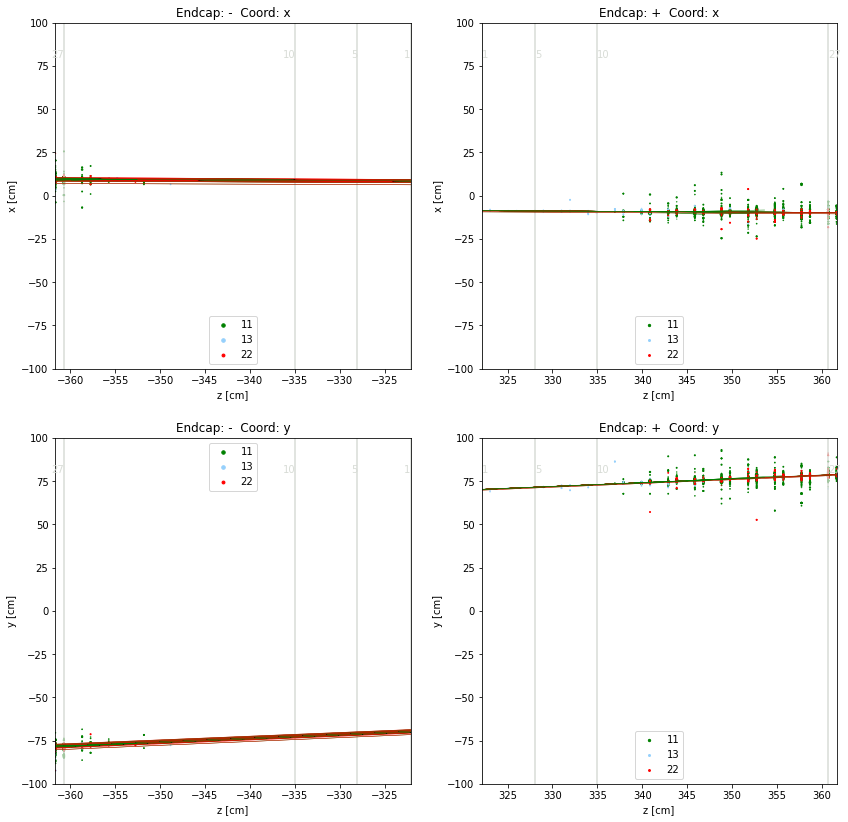

In [41]:
event_iterator = utils.get_flat_event_iterator(hits, tracks, vertices, filter=filter_energetic_photon)
for event in event_iterator:
    plotmaker(event)
    break

# Muon 'jet' cross section

event 0
  n_hits:     28965
  n_tracks:   3153
  n_vertices: 2635


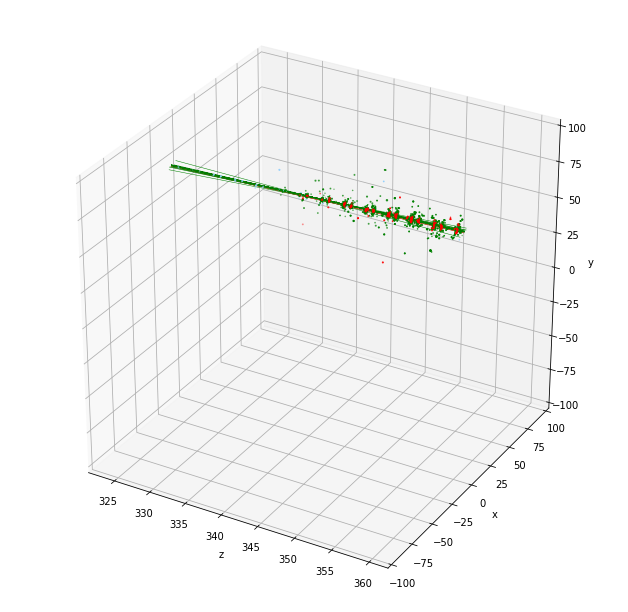

In [42]:
class Display3D(HitsPlotMaker):    
    def __init__(self):
        super(Display3D, self).__init__()

    def get_new_ax(self):
        fig = plt.figure(figsize=(11,11))
        ax = fig.add_subplot(111, projection='3d')
        return ax
    
    def trim_track(self, x, y, z, zmin, zmax):
        dx = x[1] - x[0]
        dy = y[1] - y[0]
        dz = z[1] - z[0]
        # da = math.sqrt(dx**2 + dx**2)
        # phi = math.atan(dz/da)
        # theta = math.atan(dy/dx)
        smin = (zmin - z[0]) / dz
        xmin = x[0] + smin * dx
        ymin = y[0] + smin * dy
        smax = (zmax - z[0]) / dz
        xmax = x[0] + smax * dx
        ymax = y[0] + smax * dy
        return np.array([xmin, xmax]), np.array([ymin, ymax]), np.array([zmin, zmax])
    
    def plot_endcap(self, event, endcap='+', ax=None):
        if not ax: ax = self.get_new_ax()
#         ax.view_init(0, 150)

        zmin = self.zmin_pos if endcap == '+' else self.zmin_neg
        zmax = self.zmax_pos if endcap == '+' else self.zmax_neg
        
        # Plot hits per pdgid
        unique_pdgids = np.unique(np.abs(event.hit_pdgid))
        for pdgid in unique_pdgids:
            select_hits = (np.abs(event.hit_pdgid) == pdgid) & (event.hit_z <+ zmax) & (event.hit_z >= zmin)
            ax.scatter(
                event.hit_z[select_hits],
                event.hit_x[select_hits],
                event.hit_y[select_hits],
                c = self.color(pdgid),
                s = 10000. * event.hit_energy[select_hits],
                label = '{0:0d}'.format(int(pdgid))
                )
            
        # Plot the tracks
        for i in range(event.track_z.shape[0]):
            z = [ event.track_vertex_z[i], event.track_z[i] ]
            
            # Stop prematurely for tracks outside of hgcal, since ax.plot is pretty slow
            if z[0] < zmin and z[1] < zmin:
                continue
            elif z[0] > zmax and z[1] > zmax:
                continue

            x = [ event.track_vertex_x[i], event.track_x[i] ]
            y = [ event.track_vertex_y[i], event.track_y[i] ]
            x, y, z = self.trim_track(x, y, z, zmin, zmax)

            ax.plot(
                z, x, y,
                c = self.color(event.track_pdgid[i]),
                linewidth = 0.5
                )

        ax.set_xlim(zmin, zmax)
        ax.set_xlabel('z')

        xmin = -100
        xmax = 100
        ax.set_ylim(xmin, xmax)
        ax.set_ylabel('x')
        ax.set_zlim(xmin, xmax)
        ax.set_zlabel('y')



    def plot(self, event):
        event_pos = event.select_pos()
        event_neg = event.select_neg()
        
        print(
            'event {3}\n'
            '  n_hits:     {0}\n'
            '  n_tracks:   {1}\n'
            '  n_vertices: {2}'
            .format(event.hit_z.shape[0], event.track_z.shape[0], event.vertex_z.shape[0], event.i)
            )
        
        self.plot_endcap(event_pos)
display3d = Display3D()

event_iterator = utils.get_flat_event_iterator(hits, tracks, vertices, filter=filter_energetic_photon)
for event in event_iterator:
    display3d.plot(event)
    break